# Challenge: Edit MNIST challenge images to be correctly predicted

Goal: Edit the images placed in `data/MNIST/challenge` so that the provided model predicts the correct label while keeping more than 60% of the original pixels unchanged.

Description: You are given a pre-trained `SmallCNN` model and a small set of challenge images. Your task is to minimally modify these images so the model classifies them correctly. This exercise encourages you to:

- Explore the sample dataset in `data/MNIST/sample` to understand variation and typical inputs.
- Use explainable AI (XAI) techniques (saliency maps, Grad-CAM, Integrated Gradients, occlusion, etc.) to discover what parts of the image the model relies on.
- Propose minimal edits (pixel changes, small masks, subtle color shifts) that change model prediction while preserving at least 60% of the original pixels.

Deliverables: For each edited image, save the modified image to `data/MNIST/challenge/edited/` alongside a short report (less than 2 pages) describing the XAI insights you used and the percentage of pixels preserved. For ease of use, you have the images already in that folder and you can directly work on them. You are allowed to use any external program you want to modify the image (i.e., paint, photoshop, figma, ...).

The practice can be done by more than 1 person. Final grade would depend on the number of images correctly edited (n_images_correct) with their corresponding report and number of persons working together (n_persons) following the next formula:
$$grade = 2,5 \times n\_images\_correct - 2,5 * (n\_persons - 1)$$


In [38]:
# Imports and device
import torch
import torch.nn as nn
from torchvision import transforms
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


In [39]:
# SmallCNN definition (must match the trained model architecture)
class SmallCNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 12, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.25)
        self.fc1 = nn.Linear(12 * 7 * 7, 12)
        self.fc2 = nn.Linear(12, num_classes)

    def forward(self, x):
        x = self.pool(torch.nn.functional.relu(self.conv1(x)))  # 14x14
        x = self.pool(x)  # 7x7
        x = x.view(x.size(0), -1)
        x = self.dropout(torch.nn.functional.relu(self.fc1(x)))
        return self.fc2(x)


# convenience transform
to_tensor = transforms.ToTensor()
to_pil = transforms.ToPILImage()

In [40]:
models_dir = Path("../models")
model_name = models_dir / "small_cnn.pth"
model = torch.load(model_name, weights_only=False)
model.to(device)
model.eval()

SmallCNN(
  (conv1): Conv2d(3, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.25, inplace=False)
  (fc1): Linear(in_features=588, out_features=12, bias=True)
  (fc2): Linear(in_features=12, out_features=10, bias=True)
)

0_label5.png: Pred: 1, Label: 5
1_label3.png: Pred: 1, Label: 3
2_label3.png: Pred: 1, Label: 3
3_label7.png: Pred: 3, Label: 7
4_label2.png: Pred: 6, Label: 2


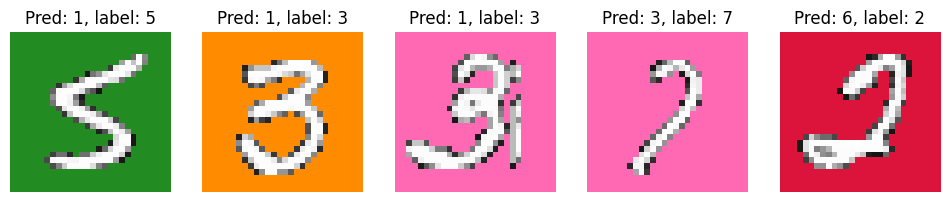

In [41]:
# Load the images in data/MNIST/challenge/ and plot them. Label of the image is the last character of the filename.
challenge_dir = Path("../data/MNIST/challenge")
image_files = list(challenge_dir.glob("*.png"))
fig, axes = plt.subplots(1, len(image_files), figsize=(12, 4))
for ax, img_file in zip(axes, image_files):
    img = to_tensor(Image.open(img_file)).unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(img)
        pred = output.argmax(dim=1).item()
    ax.imshow(to_pil(img.squeeze().cpu()))
    ax.set_title(f"Pred: {pred}, label: {img_file.stem[-1]}")
    ax.axis("off")
    print(f"{img_file.name}: Pred: {pred}, Label: {img_file.stem[-1]}")
plt.show()

---

### Any code you want to add, put it below this markdown cell


In [59]:
INITIAL_FLIP_RATIO = 0.01
MAX_FLIP_RATIO = 0.399
FLIP_RATIO_STEP = 0.01
STEP_ATTEMPTS = 1000


def perturb_image(img_tensor, flip_ratio=0.59):
    # img_tensor: (1, C, H, W)
    img = img_tensor.clone().squeeze(0).cpu().numpy()  # (C, H, W)
    C, H, W = img.shape

    num_pixels = H * W
    num_flips = int(num_pixels * flip_ratio)

    # choose spatial positions, not all elements
    idx = torch.randperm(num_pixels)[:num_flips].numpy()
    ys = idx // W
    xs = idx % W

    # flip all channels at those (y, x)
    img[:, ys, xs] = 1.0 - img[:, ys, xs]

    perturbed = (
        torch.tensor(img, dtype=torch.float32)
        .unsqueeze(0)  # back to (1, C, H, W)
        .to(device)
    )
    return perturbed


edited_dir = Path("../data/MNIST/challenge/edited")
edited_dir.mkdir(parents=True, exist_ok=True)

for img_file in image_files:
    orig_img = to_tensor(Image.open(img_file)).unsqueeze(0).to(device)
    perturbed_img = orig_img.clone()
    label = int(img_file.stem[-1])

    flip_ratio = INITIAL_FLIP_RATIO
    attempts = 0
    success = False

    while flip_ratio <= MAX_FLIP_RATIO:
        with torch.no_grad():
            output = model(perturbed_img)
            pred = output.argmax(dim=1).item()

        if pred == label:
            edited_img = to_pil(perturbed_img.squeeze().cpu())
            edited_img.save(edited_dir / img_file.name)
            print(
                f"Saved perturbed image for {img_file.name} after "
                f"{attempts} perturbations with final flip_ratio={flip_ratio:.3f}."
            )
            success = True
            break

        # generate a new perturbation from the original image
        perturbed_img = perturb_image(orig_img, flip_ratio=flip_ratio)
        attempts += 1

        # increase flip ratio every STEP_ATTEMPTS attempts, up to MAX_FLIP_RATIO
        if attempts % STEP_ATTEMPTS == 0 and flip_ratio < MAX_FLIP_RATIO:
            flip_ratio = min(MAX_FLIP_RATIO, flip_ratio + FLIP_RATIO_STEP)

    if not success:
        print(
            f"Failed to correct {img_file.name} within max flip ratio "
            f"{MAX_FLIP_RATIO:.3f} after {attempts} perturbations."
        )


Saved perturbed image for 0_label5.png after 33420 perturbations with final flip_ratio=0.340.
Saved perturbed image for 1_label3.png after 12266 perturbations with final flip_ratio=0.130.
Saved perturbed image for 2_label3.png after 11153 perturbations with final flip_ratio=0.120.
Saved perturbed image for 3_label7.png after 3 perturbations with final flip_ratio=0.010.
Saved perturbed image for 4_label2.png after 2 perturbations with final flip_ratio=0.010.


---

## Check if you have passed the challenge


In [60]:
# Check percentage of editing an image
def calculate_edit_percentage(original_img, edited_img):
    original_pixels = original_img.load()
    edited_pixels = edited_img.load()
    width, height = original_img.size
    total_pixels = width * height
    changed_pixels = 0

    for x in range(width):
        for y in range(height):
            if original_pixels[x, y] != edited_pixels[x, y]:
                changed_pixels += 1

    return (changed_pixels / total_pixels) * 100

In [61]:
# Create edited directory
edited_dir = challenge_dir / "edited"

# Load edited images, check that they are predicted correctly and calculate edit percentages
for original_img_file, edited_img_file in zip(
    challenge_dir.glob("*.png"), edited_dir.glob("*.png")
):
    original_img = Image.open(original_img_file)
    edited_img = Image.open(edited_img_file)
    # Convert the edited image to RGB if it's not
    if edited_img.mode != "RGB":
        edited_img = edited_img.convert("RGB")

    # Check prediction
    img_tensor = to_tensor(edited_img).unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(img_tensor)
        pred = output.argmax(dim=1).item()

    print(
        f"Edited {edited_img_file.name}: Pred: {pred}, Label: {original_img_file.stem[-1]}, correct: {pred == int(original_img_file.stem[-1])}"
    )

    # Calculate edit percentage
    edit_percentage = calculate_edit_percentage(original_img, edited_img)
    print(f"Edit Percentage: {edit_percentage:.2f}%")


Edited 0_label5.png: Pred: 5, Label: 5, correct: True
Edit Percentage: 33.93%
Edited 1_label3.png: Pred: 3, Label: 3, correct: True
Edit Percentage: 12.88%
Edited 2_label3.png: Pred: 3, Label: 3, correct: True
Edit Percentage: 11.99%
Edited 3_label7.png: Pred: 7, Label: 7, correct: True
Edit Percentage: 0.89%
Edited 4_label2.png: Pred: 2, Label: 2, correct: True
Edit Percentage: 0.89%


## Conclusion


Vemos que cambiando aleatoriamente el 33% de los pixeles podemos conseguir que el modelo clasifique correctamente las imágenes del reto. La primera es la mas dificil de cambiar, pero el resto con muy pocos pixeles pertubados cambia completamente la prediccion (el 7 cambia con solo 4 pixeles). Esto indica que el modelo es muy muy poco robusto. Las images editadas siguen mantieniendo claramente el dígito original, pero el modelo no es capaz de reconocerlo.

Se ha comprobado que los gradientes son muy pequeños por culpa de la ReLU, por lo que las tecnicas de XAI basadas en gradientes no son muy efectivas en este caso, asi que he optado por el enfoque mas simple de ir cambiando pixeles aleatoriamente hasta conseguir que la prediccion sea correcta y funciona bastante bien.


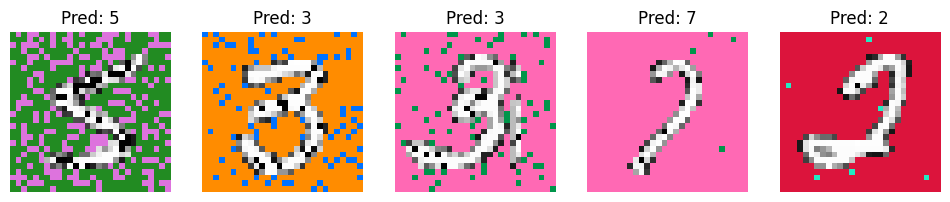

In [62]:
# Plot edited images with their predictions
fig, axes = plt.subplots(1, len(image_files), figsize=(12, 4))
for ax, edited_img_file in zip(axes, edited_dir.glob("*.png")):
    edited_img = to_tensor(Image.open(edited_img_file)).unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(edited_img)
        pred = output.argmax(dim=1).item()
    ax.imshow(to_pil(edited_img.squeeze().cpu()))
    ax.set_title(f"Pred: {pred}")
    ax.axis("off")
plt.show()
